# 지하철 승하차 정보 공공데이터 분석

# > 데이터 설명

### 1. 지하철 역별 승하차 인원 정보 (23.06.07~23.07.15)

교통카드(선후불교통카드 및 1회용 교통카드)를 이용한 지하철 호선별 역별(서울교통공사, 한국철도공사, 공항철도, 9호선) 승하차인원을 나타내는 정보입니다. (일단위)

    data.seoul.go.kr/dataList/OA-12914/S/1/datasetView.do
    
### 2. 지하철 역 정보

서울교통공사에서 제공하는 관할역명으로 지하철역 검색하는 정보에 관한 API 입니다. 해당 정보는 전철역코드, 전철역명, 호선 등을 제공합니다.

    data.seoul.go.kr/dataList/OA-121/S/1/datasetView.do

#### ※ 본 데이터는 완벽하게 모든 역의 승하차 정보를 담고 있지 않음. 일부 역의 경우 관리하는 주무부처가 달라서 데이터가 없다고 함. 그래도 메인 역 정보는 대부분 가지고 있는 것 같음. 없는 데이터를 수집하는데 시간을 많이 들이기보다는 주어진 공공데이터를 활용해서 재미삼아 살펴보기로 한다.

#### ※ 환승역의 경우 각 호선별로 데이터를 가지고 있는데 굳이 합치지 않는다.

... 지하철 역별 승하차 인원 정보를 분석하고 싶은데 승하차 인원 정보만으로는 역 순서를 알 수가 없음. 따라서 지하철 역 정보를 활용하여 전철역코드를 맵핑하여 분석할 예정.

# > 궁금한 것

#### 1. 출퇴근하다 보면 월요일엔 사람이 많고 금요일에는 지하철에 유난히 사람이 적은 것 같은데 실제로 그런가?
#### 2. 실제로 주요 역(강남역 등)의 유동인구는 일반적으로 내가 다니는 곳에 비해 얼마나 더 많은가?

***

# 1. Import Libraries

In [ ]:
import pandas as pd
import pandas_profiling

from scipy.stats import ttest_1samp

import matplotlib as mpl
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'UnDotum'
plt.rcParams['font.size'] = 13

# 2. Load Data

In [119]:
subway_congestion = pd.read_csv('data/서울시 지하철호선별 역별 승하차 인원 정보.csv', encoding='cp949')
subway_station = pd.read_csv('data/서울교통공사 노선별 지하철역 정보.csv', encoding='cp949')

# 3. At a glance

### 1) 지하철 역별 승하차 인원 정보

In [120]:
subway_congestion

,사용일자,호선명,역명,승차총승객수,하차총승객수,등록일자
0,20230715,우이신설선,4.19민주묘지,2341,2133,20230718
1,20230715,경원선,가능,5015,4756,20230718
2,20230715,3호선,가락시장,6230,5775,20230718
3,20230715,8호선,가락시장,5445,5562,20230718
4,20230715,7호선,가산디지털단지,13892,12723,20230718
...,...,...,...,...,...,...
23108,20230607,경원선,회룡,14770,14560,20230610
23109,20230607,4호선,회현(남대문시장),29123,30778,20230610
23110,20230607,6호선,효창공원앞,8705,8129,20230610
23111,20230607,경의선,효창공원앞,3958,4225,20230610


In [4]:
pr = subway_congestion.profile_report()
pr

모든 컬럼에 결측치가 없다.

### 2) 지하철 역 정보

In [121]:
subway_station

,전철역코드,전철역명,전철명명(영문),호선,외부코드,전철명명(중문),전철명명(일문)
0,0244,용답,Yongdap,02호선,211-1,龍踏,龍踏
1,0245,신답,Sindap,02호선,211-2,新踏,新踏
2,0250,용두,Yongdu,02호선,211-3,龍頭,龍頭
3,0336,학여울,Hangnyeoul,03호선,346,Hangnyeoul,ハンニョウル
4,0428,삼각지,Samgakji,04호선,428,三角地,三角地
...,...,...,...,...,...,...,...
768,0159,동묘앞,Dongmyo,01호선,127,東廟,東廟前
769,0200,까치산,Kkachisan,02호선,234-4,喜鵲山,カチ山
770,0201,시청,City Hall,02호선,201,市廳,市廳
771,0202,을지로입구,Euljiro 1(il)-ga,02호선,202,乙支路入口,乙支路入口


In [35]:
pr = subway_station.profile_report()
pr

우리에게 필요한 전철역코드, 전철역명, 호선에만 결측치가 없으면 된다.

# 3. 데이터 전처리

### 1) 필요한 컬럼 추출 및 데이터프레임 병합

In [122]:
# 등록일자 컬럼 삭제
subway_congestion = subway_congestion.drop('등록일자', axis=1)
subway_congestion

,사용일자,호선명,역명,승차총승객수,하차총승객수
0,20230715,우이신설선,4.19민주묘지,2341,2133
1,20230715,경원선,가능,5015,4756
2,20230715,3호선,가락시장,6230,5775
3,20230715,8호선,가락시장,5445,5562
4,20230715,7호선,가산디지털단지,13892,12723
...,...,...,...,...,...
23108,20230607,경원선,회룡,14770,14560
23109,20230607,4호선,회현(남대문시장),29123,30778
23110,20230607,6호선,효창공원앞,8705,8129
23111,20230607,경의선,효창공원앞,3958,4225


In [123]:
subway_station = subway_station[['전철역코드','전철역명']]
subway_station

,전철역코드,전철역명
0,0244,용답
1,0245,신답
2,0250,용두
3,0336,학여울
4,0428,삼각지
...,...,...
768,0159,동묘앞
769,0200,까치산
770,0201,시청
771,0202,을지로입구


In [124]:
subway_station = subway_station.rename(columns={'전철역명': '역명'})

In [125]:
df = pd.merge(subway_congestion, subway_station, on='역명', how='left')

In [126]:
df

,사용일자,호선명,역명,승차총승객수,하차총승객수,전철역코드
0,20230715,우이신설선,4.19민주묘지,2341,2133,NaN
1,20230715,경원선,가능,5015,4756,1907
2,20230715,3호선,가락시장,6230,5775,0340
3,20230715,3호선,가락시장,6230,5775,2818
4,20230715,8호선,가락시장,5445,5562,0340
...,...,...,...,...,...,...
30924,20230607,6호선,효창공원앞,8705,8129,1261
30925,20230607,6호선,효창공원앞,8705,8129,2628
30926,20230607,경의선,효창공원앞,3958,4225,1261
30927,20230607,경의선,효창공원앞,3958,4225,2628


우이신설선 같은 경우 전철역코드가 없어도 상관없다. 그런데 흑석(중앙대입구)는 9호선인데 왜 없을까?

In [127]:
subway_station[subway_station['역명'].str.contains('흑석')]

,전철역코드,역명
635,4119,흑석


두 테이블 간 역명이 다른 게 있음을 발견했다.

In [128]:
df.isnull().sum()

사용일자         0
호선명          0
역명           0
승차총승객수       0
하차총승객수       0
전철역코드     3002
dtype: int64

전철역코드에 문제가 있다.

In [129]:
df[df.isnull().any(axis=1)]

,사용일자,호선명,역명,승차총승객수,하차총승객수,전철역코드
0,20230715,우이신설선,4.19민주묘지,2341,2133,NaN
26,20230715,2호선,강변(동서울터미널),26375,26395,NaN
43,20230715,3호선,경복궁(정부서울청사),20705,19318,NaN
48,20230715,6호선,고려대(종암),5401,5021,NaN
79,20230715,7호선,공릉(서울과학기술대),8680,8376,NaN
...,...,...,...,...,...,...
30882,20230607,5호선,하남시청(덕풍?신장),8533,8131,NaN
30890,20230607,4호선,한성대입구(삼선교),16124,15593,NaN
30914,20230607,6호선,화랑대(서울여대입구),14447,11144,NaN
30923,20230607,4호선,회현(남대문시장),29123,30778,NaN


대략 살펴보니 .이나 () 같은 특수문자가 들어간 경우 뭔가 맵핑이 안된 것 같다.

In [130]:
subway_station[subway_station['역명'].str.contains('흑석')]

,전철역코드,역명
635,4119,흑석


In [131]:
subway_station[subway_station['역명'].str.contains('공릉')]

,전철역코드,역명
493,2718,공릉


In [132]:
subway_station[subway_station['역명'].str.contains('하남시청')]

,전철역코드,역명
450,2565,하남시청


In [133]:
subway_station[subway_station['역명'].str.contains('민주묘지')]

,전철역코드,역명
743,4703,4?19민주묘지


subway_station에 있는 ?를 .으로 바꾸고 괄호 안의 글자는 괄호와 함께 날려버려야겠다

In [134]:
subway_station

,전철역코드,역명
0,0244,용답
1,0245,신답
2,0250,용두
3,0336,학여울
4,0428,삼각지
...,...,...
768,0159,동묘앞
769,0200,까치산
770,0201,시청
771,0202,을지로입구


In [135]:
# ?를 .으로 바꾸기
subway_station['역명'] = subway_station['역명'].str.replace('?', '.')

In [136]:
subway_station[subway_station['역명'].str.contains('민주묘지')]

,전철역코드,역명
743,4703,4.19민주묘지


In [137]:
# 괄호 안 날려버리기
subway_congestion['역명'] = subway_congestion['역명'].str.replace(r'\([^)]*\)', '', regex=True)

In [138]:
subway_congestion

,사용일자,호선명,역명,승차총승객수,하차총승객수
0,20230715,우이신설선,4.19민주묘지,2341,2133
1,20230715,경원선,가능,5015,4756
2,20230715,3호선,가락시장,6230,5775
3,20230715,8호선,가락시장,5445,5562
4,20230715,7호선,가산디지털단지,13892,12723
...,...,...,...,...,...
23108,20230607,경원선,회룡,14770,14560
23109,20230607,4호선,회현,29123,30778
23110,20230607,6호선,효창공원앞,8705,8129
23111,20230607,경의선,효창공원앞,3958,4225


이제 다시 병합해보자

In [139]:
df = pd.merge(subway_congestion, subway_station, on='역명', how='left')
df

,사용일자,호선명,역명,승차총승객수,하차총승객수,전철역코드
0,20230715,우이신설선,4.19민주묘지,2341,2133,4703
1,20230715,경원선,가능,5015,4756,1907
2,20230715,3호선,가락시장,6230,5775,0340
3,20230715,3호선,가락시장,6230,5775,2818
4,20230715,8호선,가락시장,5445,5562,0340
...,...,...,...,...,...,...
32824,20230607,6호선,효창공원앞,8705,8129,1261
32825,20230607,6호선,효창공원앞,8705,8129,2628
32826,20230607,경의선,효창공원앞,3958,4225,1261
32827,20230607,경의선,효창공원앞,3958,4225,2628


In [140]:
df.isnull().sum()

사용일자      0
호선명       0
역명        0
승차총승객수    0
하차총승객수    0
전철역코드     0
dtype: int64

짠

### 2) 날짜 컬럼 생성

In [141]:
df['날짜'] = pd.to_datetime(df['사용일자'], format='%Y%m%d')

In [142]:
df = df.drop(columns='사용일자', axis=1)

In [143]:
df

,호선명,역명,승차총승객수,하차총승객수,전철역코드,날짜
0,우이신설선,4.19민주묘지,2341,2133,4703,2023-07-15
1,경원선,가능,5015,4756,1907,2023-07-15
2,3호선,가락시장,6230,5775,0340,2023-07-15
3,3호선,가락시장,6230,5775,2818,2023-07-15
4,8호선,가락시장,5445,5562,0340,2023-07-15
...,...,...,...,...,...,...
32824,6호선,효창공원앞,8705,8129,1261,2023-06-07
32825,6호선,효창공원앞,8705,8129,2628,2023-06-07
32826,경의선,효창공원앞,3958,4225,1261,2023-06-07
32827,경의선,효창공원앞,3958,4225,2628,2023-06-07


### 3) 요일 추가

In [144]:
df['요일'] = df['날짜'].dt.day_name()

In [145]:
df

,호선명,역명,승차총승객수,하차총승객수,전철역코드,날짜,요일
0,우이신설선,4.19민주묘지,2341,2133,4703,2023-07-15,Saturday
1,경원선,가능,5015,4756,1907,2023-07-15,Saturday
2,3호선,가락시장,6230,5775,0340,2023-07-15,Saturday
3,3호선,가락시장,6230,5775,2818,2023-07-15,Saturday
4,8호선,가락시장,5445,5562,0340,2023-07-15,Saturday
...,...,...,...,...,...,...,...
32824,6호선,효창공원앞,8705,8129,1261,2023-06-07,Wednesday
32825,6호선,효창공원앞,8705,8129,2628,2023-06-07,Wednesday
32826,경의선,효창공원앞,3958,4225,1261,2023-06-07,Wednesday
32827,경의선,효창공원앞,3958,4225,2628,2023-06-07,Wednesday


In [146]:
# 최종 dataframe
df = df[['날짜','요일','호선명','전철역코드','역명','승차총승객수','하차총승객수']].sort_values(by='전철역코드')
df

,날짜,요일,호선명,전철역코드,역명,승차총승객수,하차총승객수
27218,2023-06-13,Tuesday,경의선,0150,서울역,5566,7032
27222,2023-06-13,Tuesday,공항철도 1호선,0150,서울역,11550,10131
28071,2023-06-12,Monday,공항철도 1호선,0150,서울역,12439,11032
16028,2023-06-26,Monday,공항철도 1호선,0150,서울역,13304,11568
9969,2023-07-03,Monday,경부선,0150,서울역,8099,2581
...,...,...,...,...,...,...,...
17471,2023-06-24,Saturday,공항철도 1호선,4929,김포공항,11363,5609
26086,2023-06-14,Wednesday,공항철도 1호선,4929,김포공항,11790,6843
17466,2023-06-24,Saturday,9호선,4929,김포공항,8612,12637
30390,2023-06-09,Friday,5호선,4929,김포공항,8706,7762


### 4) 필요한 호선만 선별

### 호선명 컬럼에 값이 너무 많다. 서울 지하철노선 중 평소 대중적으로 이용하는 것들만 뽑자.

In [147]:
df.호선명.unique()

array(['경의선', '공항철도 1호선', '경부선', '1호선', '4호선', '2호선', '3호선', '5호선',
       '우이신설선', '경원선', '6호선', '7호선', '8호선', '9호선2~3단계', '분당선', '신림선',
       '9호선', '일산선', '중앙선', '경춘선', '장항선', '과천선', '경강선', '안산선', '경인선',
       '수인선', '서해선'], dtype=object)

조사를 하면서 알게 된 사실이지만 9호선에 2, 3단계가 있었다.

2단계 및 3단계 구간은 신논현역 ↔ 중앙보훈병원역인데 9호선과 9호선2~3단계를 합치면 되겠다.

#### 9호선 2~3단계를 9호선으로 바꿔준다.

In [148]:
df['호선명'] = df['호선명'].replace('9호선2~3단계','9호선')

In [149]:
df.호선명.unique()

array(['경의선', '공항철도 1호선', '경부선', '1호선', '4호선', '2호선', '3호선', '5호선',
       '우이신설선', '경원선', '6호선', '7호선', '8호선', '9호선', '분당선', '신림선', '일산선',
       '중앙선', '경춘선', '장항선', '과천선', '경강선', '안산선', '경인선', '수인선', '서해선'],
      dtype=object)

#### 경의선과 중앙선을 경의중앙선으로 바꾼다.

In [150]:
df['호선명'] = df['호선명'].replace('경의선','경의중앙선')
df['호선명'] = df['호선명'].replace('중앙선','경의중앙선')

In [151]:
df.호선명.unique()

array(['경의중앙선', '공항철도 1호선', '경부선', '1호선', '4호선', '2호선', '3호선', '5호선',
       '우이신설선', '경원선', '6호선', '7호선', '8호선', '9호선', '분당선', '신림선', '일산선',
       '경춘선', '장항선', '과천선', '경강선', '안산선', '경인선', '수인선', '서해선'],
      dtype=object)

#### 수인선은 그냥 삭제하고 분당선만 보기로 한다.

### 필요한 컬럼만 선별

In [152]:
df = df.loc[df['호선명'].isin(['1호선','2호선','3호선','4호선','5호선','6호선','7호선','8호선','9호선','분당선','경의중앙선'])]

In [153]:
df

,날짜,요일,호선명,전철역코드,역명,승차총승객수,하차총승객수
27218,2023-06-13,Tuesday,경의중앙선,0150,서울역,5566,7032
28067,2023-06-12,Monday,경의중앙선,0150,서울역,5611,7107
30652,2023-06-09,Friday,1호선,0150,서울역,60513,58360
9977,2023-07-03,Monday,1호선,0150,서울역,53435,51030
9981,2023-07-03,Monday,경의중앙선,0150,서울역,5001,6614
...,...,...,...,...,...,...,...
26076,2023-06-14,Wednesday,9호선,4929,김포공항,7728,11699
26081,2023-06-14,Wednesday,5호선,4929,김포공항,8397,7594
17466,2023-06-24,Saturday,9호선,4929,김포공항,8612,12637
30390,2023-06-09,Friday,5호선,4929,김포공항,8706,7762


### 5) 분석에 필요한 새로운 컬럼 만들기

In [154]:
# 승하차총승객수
df['승하차총승객수'] = df['승차총승객수'] + df['하차총승객수']

In [155]:
# 승하차비율
df['승하차비율'] = df['하차총승객수']/df['승차총승객수']

In [156]:
# 승하차차이
df['승하차차이'] = df['승차총승객수'] - df['하차총승객수']

In [157]:
df

,날짜,요일,호선명,전철역코드,역명,승차총승객수,하차총승객수,승하차총승객수,승하차비율,승하차차이
27218,2023-06-13,Tuesday,경의중앙선,0150,서울역,5566,7032,12598,1.263385,-1466
28067,2023-06-12,Monday,경의중앙선,0150,서울역,5611,7107,12718,1.266619,-1496
30652,2023-06-09,Friday,1호선,0150,서울역,60513,58360,118873,0.964421,2153
9977,2023-07-03,Monday,1호선,0150,서울역,53435,51030,104465,0.954992,2405
9981,2023-07-03,Monday,경의중앙선,0150,서울역,5001,6614,11615,1.322535,-1613
...,...,...,...,...,...,...,...,...,...,...
26076,2023-06-14,Wednesday,9호선,4929,김포공항,7728,11699,19427,1.513846,-3971
26081,2023-06-14,Wednesday,5호선,4929,김포공항,8397,7594,15991,0.904371,803
17466,2023-06-24,Saturday,9호선,4929,김포공항,8612,12637,21249,1.467371,-4025
30390,2023-06-09,Friday,5호선,4929,김포공항,8706,7762,16468,0.891569,944


# 4. Explore Data

### 1. 여기서 궁금한 점은 승차총승객수와 하차총승객수는 얼마나 차이 날까?


#### 나의 가설 : 큰 차이 없을 것이다.


특정 시간대, 특정 이벤트가 있는 날의 경우 (야구 경기 등) 내리는 사람이 많거나 할 수 있지만, 결국 하루 유동인구를 합쳐 보면 그 수가 크게 차이 나지 않을 것이다. (맨 처음 또는 마지막 역은 타는 사람만 있거나 내리는 사람만 있을 것이다)

#### 1) 간략한 숫자 확인

In [158]:
df_pivot = pd.pivot_table(df, index = '호선명', aggfunc='mean').sort_values('승하차총승객수', ascending=False)
df_pivot

,승차총승객수,승하차비율,승하차차이,승하차총승객수,하차총승객수
호선명,,,,,
2호선,28390.094467,1.019922,-483.398448,57263.587382,28873.492915
1호선,24999.149886,0.972348,895.826087,49102.473684,24103.323799
4호선,17900.984211,1.089867,-855.371053,36657.339474,18756.355263
3호선,16326.373832,0.958322,183.436137,32469.311526,16142.937695
7호선,13959.499308,0.969794,305.603965,27613.394652,13653.895343
9호선,10840.331579,1.037313,-441.057895,22121.721053,11281.389474
분당선,10534.928246,0.998258,-422.162301,21492.018793,10957.090547
5호선,10634.464698,1.000303,23.563222,21245.366175,10610.901476
8호선,10120.614035,1.011253,-203.146930,20444.375000,10323.760965


평균 승하차총승객수가 압도적인 2호선과 마의 1호선..

In [159]:
df_pivot = pd.pivot_table(df, index = '호선명', aggfunc='mean')

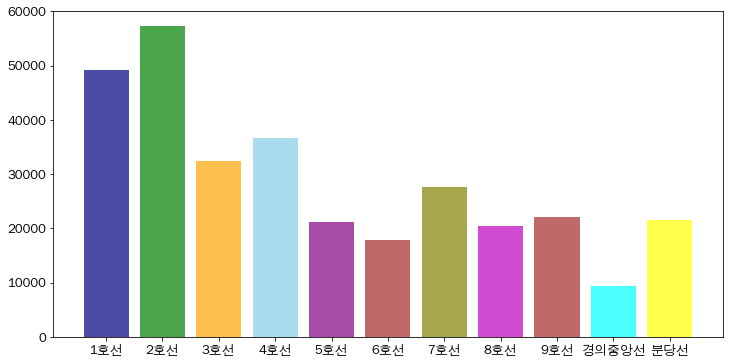

In [161]:
fig, ax = plt.subplots(figsize=(12,6))

plt.bar(df_pivot.index, df_pivot['승하차총승객수'],
        color=['navy','green','orange','skyblue','purple','brown','olive','m','brown','cyan','yellow'], alpha=.7)

plt.show()

#### 2) 독립표본 t-test 검정

승차총승객수 평균과 하차총승객수 평균의 차이를 검정하기 위해 각 호선별로 승하차차이를 이용해 독립표본 t-test를 진행한다 (유의수준 0.05)

귀무가설 (Null Hypothesis, H0): 승차총승객수와 하차총승객수 사이의 평균 차이가 없다.


대립가설 (Alternative Hypothesis, Ha): 승차총승객수와 하차총승객수 사이의 평균 차이가 있다.

In [162]:
# 각 호선별로 t-검정 수행
for _, group in df.groupby('호선명'):
    t_stat, p_value = ttest_1samp(group['승하차차이'], 0)
    print(f"호선명: {group['호선명'].iloc[0]}, t-statistic: {t_stat}, p-value: {p_value}")

호선명: 1호선, t-statistic: 20.50019913211897, p-value: 1.5013539622146513e-76
호선명: 2호선, t-statistic: -9.838658564414812, p-value: 1.6902267990472966e-22
호선명: 3호선, t-statistic: 4.212337796836365, p-value: 2.644108225464244e-05
호선명: 4호선, t-statistic: -11.080636905833476, p-value: 1.7062088891958835e-27
호선명: 5호선, t-statistic: 1.5969611020451597, p-value: 0.11037580978645846
호선명: 6호선, t-statistic: 4.614486144117203, p-value: 4.181811741694999e-06
호선명: 7호선, t-statistic: 11.71863204182446, p-value: 8.502923159409516e-31
호선명: 8호선, t-statistic: -4.562058883875936, p-value: 5.758212190905045e-06
호선명: 9호선, t-statistic: -11.220672414457352, p-value: 2.059687383937915e-28
호선명: 경의중앙선, t-statistic: 10.397416079625671, p-value: 7.759509615199845e-25
호선명: 분당선, t-statistic: -11.15582563776182, p-value: 5.708295261912186e-28


#### 3) 결과 해석

모든 호선의 p-value가 0.05보다 크므로 귀무가설을 기각하지 않는다. 즉, 승차총승객수와 하차총승객수의 차이는 통계적으로 유의미하지 않다.

승차총승객수와 하차총승객수를 더해서 그날의 유동인구로 생각하고 분석해보자.

# 5. 분석

## 1) 출퇴근하다 보면 월요일엔 사람이 많고 금요일에는 지하철에 유난히 사람이 적은 것 같은데 실제로 그런가?


In [163]:
# pivot_df = pd.pivot_table(df, index='Name', columns='Subject', values='Score', aggfunc='mean')
df_pivot1 = pd.pivot_table(df, index='호선명', columns='요일', values='승하차총승객수', aggfunc='sum')
df_pivot1 = df_pivot1[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
df_pivot1

요일,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
호선명,,,,,,,
1호선,5881684,5974188,6086646,7309910,7835635,6173683,3653816
2호선,23499140,24166210,24659936,29410924,31242435,23210368,13540260
3호선,8698420,8871041,8991453,10775227,11585635,8599141,5014977
4호선,7729725,7926257,8148203,9601917,10109264,7663100,4540690
5호선,9530964,9753526,9941519,11777409,12187792,8211199,4798152
6호선,5260797,5401156,5525739,6520696,6721036,4674623,2799905
7호선,8783455,8923290,9087533,10668392,11029736,7157486,4243561
8호선,2665883,2730405,2776683,3287238,3408746,2369290,1407025
9호선,6459914,6601641,6674240,8032284,8525809,6123029,3817480


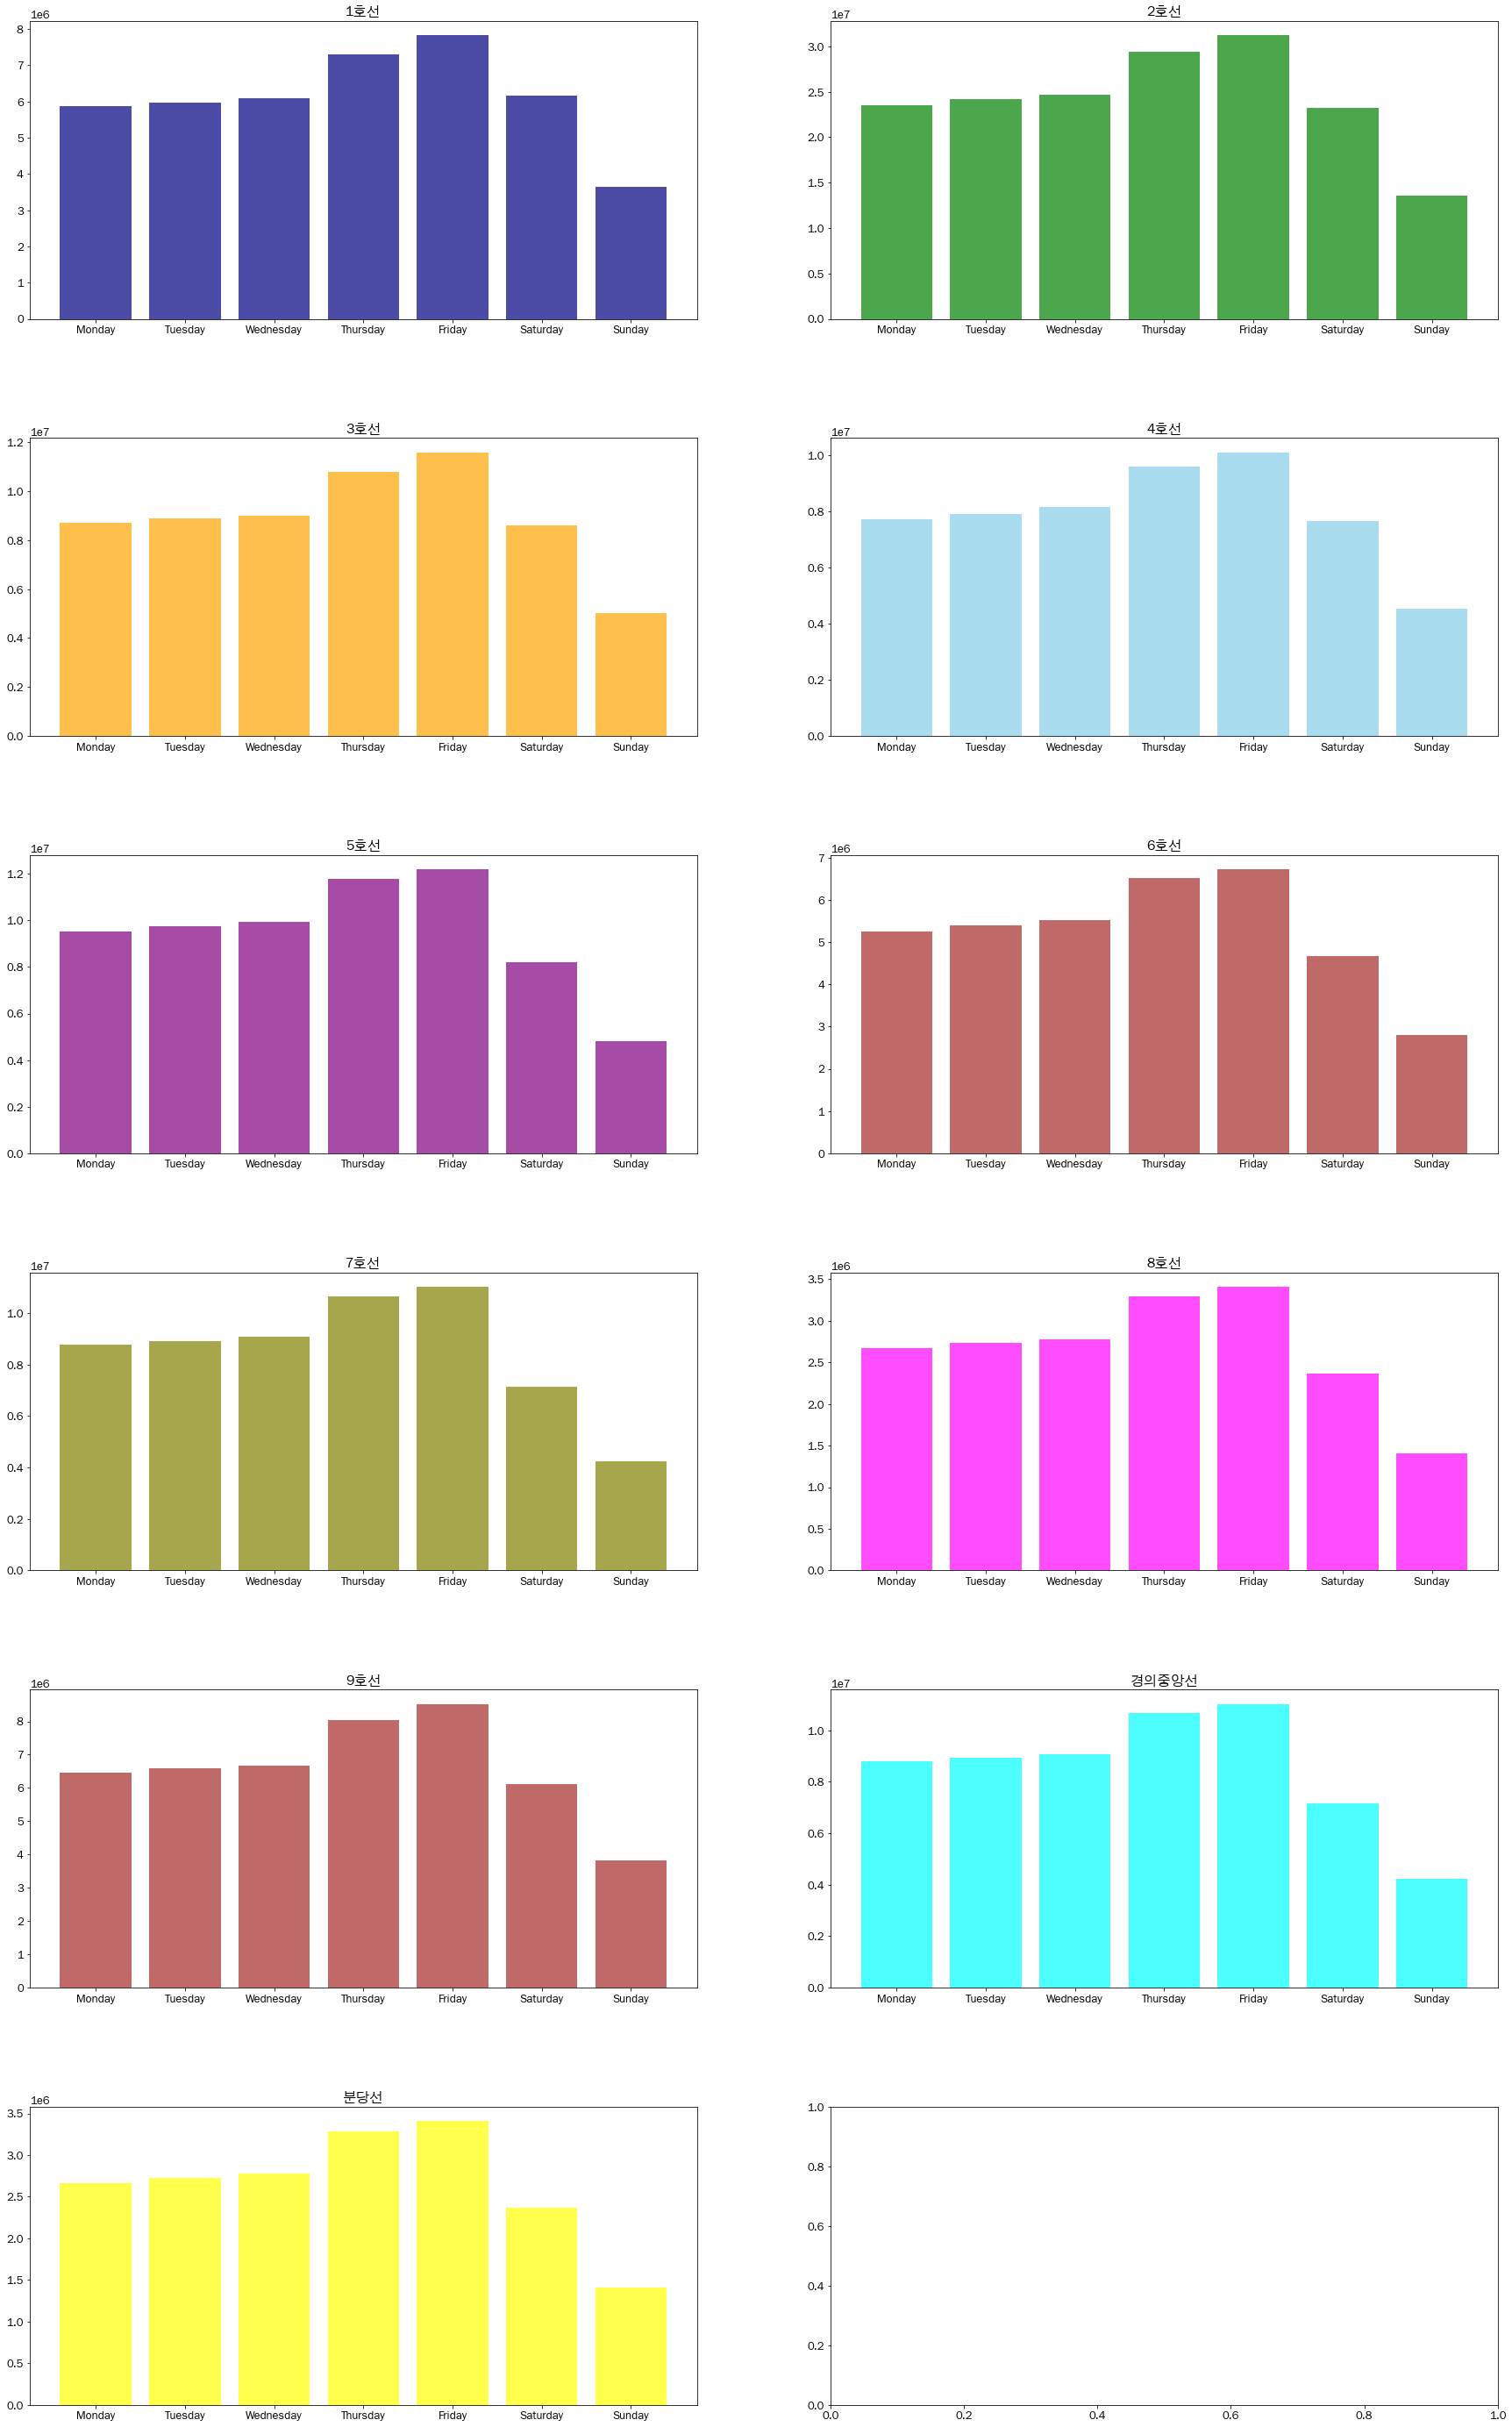

In [164]:
fig, ax = plt.subplots(6, 2, figsize=(30, 50), gridspec_kw={'hspace': 0.4})

ax[0,0].bar(df_pivot1.columns, df_pivot1.iloc[0], color='navy', alpha=.7)
ax[0,0].set_title('1호선')

ax[0,1].bar(df_pivot1.columns, df_pivot1.iloc[1], color='green', alpha=.7)
ax[0,1].set_title('2호선')

ax[1,0].bar(df_pivot1.columns, df_pivot1.iloc[2], color='orange', alpha=.7)
ax[1,0].set_title('3호선')

ax[1,1].bar(df_pivot1.columns, df_pivot1.iloc[3], color='skyblue', alpha=.7)
ax[1,1].set_title('4호선')

ax[2,0].bar(df_pivot1.columns, df_pivot1.iloc[4], color='purple', alpha=.7)
ax[2,0].set_title('5호선')

ax[2,1].bar(df_pivot1.columns, df_pivot1.iloc[5], color='brown', alpha=.7)
ax[2,1].set_title('6호선')

ax[3,0].bar(df_pivot1.columns, df_pivot1.iloc[6], color='olive', alpha=.7)
ax[3,0].set_title('7호선')

ax[3,1].bar(df_pivot1.columns, df_pivot1.iloc[7], color='magenta', alpha=.7)
ax[3,1].set_title('8호선')

ax[4,0].bar(df_pivot1.columns, df_pivot1.iloc[8], color='brown', alpha=.7)
ax[4,0].set_title('9호선')

ax[4,1].bar(df_pivot1.columns, df_pivot1.iloc[6], color='cyan', alpha=.7)
ax[4,1].set_title('경의중앙선')

ax[5,0].bar(df_pivot1.columns, df_pivot1.iloc[7], color='yellow', alpha=.7)
ax[5,0].set_title('분당선')

plt.show()

[결론]

숫자 말고 추세만 보면 오히려 월, 화, 수 비슷하다가 목요일을 넘어 금요일에 제일 많다..

시간대별로 보면 다른 결과가 나올 수도 있지만 어쨌든 가지고 있는 데이터로만 봤을 때 하루 총 유동인구로 보면 큰 차이가 없다.

아무래도 마음의 문제인 것일까..? 월요일엔 출근하기 싫고 금요일엔 발걸음이 가벼운 탓일까.

#### 이 분석을 하고 나서 출퇴근길 지하철에서 유심히 관찰했는데 진짜 금요일이 제일 많은 것 같았다.
#### 역시 데이터 분석은 감정에 휘둘리지 않고 현실을 똑바로 볼 수 있게 해주는 도구인가?!?

## 2) 실제로 주요 역(강남역 등)의 유동인구는 일반적으로 내가 다니는 곳에 비해 얼마나 더 많은가?

#### 나는 거의 10년째 분당선을 타고 다닌다.

## 2-1) 분당선 살펴보기

### 분당선 데이터 추출

In [166]:
df_bd = df[df['호선명'] == '분당선'].copy()
df_bd

,날짜,요일,호선명,전철역코드,역명,승차총승객수,하차총승객수,승하차총승객수,승하차비율,승하차차이
7389,2023-07-06,Thursday,분당선,0220,선릉,15395,23455,38850,1.523547,-8060
16910,2023-06-25,Sunday,분당선,0220,선릉,3100,4766,7866,1.537419,-1666
6518,2023-07-07,Friday,분당선,0220,선릉,14924,22987,37911,1.540271,-8063
9130,2023-07-04,Tuesday,분당선,0220,선릉,15526,23024,38550,1.482932,-7498
17769,2023-06-24,Saturday,분당선,0220,선릉,5929,9331,15260,1.573790,-3402
...,...,...,...,...,...,...,...,...,...,...
23481,2023-06-17,Saturday,분당선,4501,기흥,8049,7426,15475,0.922599,623
11421,2023-07-01,Saturday,분당선,4501,기흥,7481,7070,14551,0.945061,411
28649,2023-06-11,Sunday,분당선,4501,기흥,5316,5092,10408,0.957863,224
24345,2023-06-16,Friday,분당선,4501,기흥,11576,10821,22397,0.934779,755


In [167]:
df_bd['역명'].unique()

array(['선릉', '도곡', '수서', '한티', '구룡', '개포동', '대모산입구', '복정', '이매', '수원',
       '서울숲', '압구정로데오', '강남구청', '선정릉', '가천대', '태평', '모란', '야탑', '서현',
       '수내', '정자', '미금', '오리', '보정', '죽전', '구성', '신갈', '기흥', '상갈', '청명',
       '영통', '망포', '매탄권선', '수원시청', '매교'], dtype=object)

In [168]:
# 분당선 역 리스트 by 나무위키
bd_station_list = ['왕십리','서울숲','압구정로데오','강남구청','선정릉','선릉','한티','도곡','구룡','개포동','대모산입구',
             '수서','복정','가천대','태평','모란','야탑','이매','서현','수내','정자','미금','오리','죽전','보정','구성','신갈',
             '기흥','상갈','청명','영통','망포','매탄권선','수원시청','매교','수원']

In [169]:
# 실제 역 갯수와 차이
len(bd_station_list) - len(df_bd['역명'].unique())

1

In [170]:
# df_bd에만 있는 값 찾기
unique_in_df_bd = [x for x in df_bd['역명'].unique() if x not in bd_station_list]
unique_in_df_bd

[]

In [171]:
# bd_station_list에만 있는 값 찾기
unique_in_bd_station_list = [x for x in bd_station_list if x not in df_bd['역명'].unique()]
unique_in_bd_station_list

['왕십리']

아쉽게 킹십리는 없지만 그 외 모든 역이 다 있다. 분당선 역 갯수는 원래 36개인데 우리가 가진 데이터는 35개.

In [172]:
df_bd

,날짜,요일,호선명,전철역코드,역명,승차총승객수,하차총승객수,승하차총승객수,승하차비율,승하차차이
7389,2023-07-06,Thursday,분당선,0220,선릉,15395,23455,38850,1.523547,-8060
16910,2023-06-25,Sunday,분당선,0220,선릉,3100,4766,7866,1.537419,-1666
6518,2023-07-07,Friday,분당선,0220,선릉,14924,22987,37911,1.540271,-8063
9130,2023-07-04,Tuesday,분당선,0220,선릉,15526,23024,38550,1.482932,-7498
17769,2023-06-24,Saturday,분당선,0220,선릉,5929,9331,15260,1.573790,-3402
...,...,...,...,...,...,...,...,...,...,...
23481,2023-06-17,Saturday,분당선,4501,기흥,8049,7426,15475,0.922599,623
11421,2023-07-01,Saturday,분당선,4501,기흥,7481,7070,14551,0.945061,411
28649,2023-06-11,Sunday,분당선,4501,기흥,5316,5092,10408,0.957863,224
24345,2023-06-16,Friday,분당선,4501,기흥,11576,10821,22397,0.934779,755


### 분당선 역별 승하차 승객 수 비교 (sum, mean)

In [175]:
df_pivot_bd_sum = pd.pivot_table(df_bd, index = '역명', aggfunc='sum').sort_values('승하차총승객수', ascending=False)
df_pivot_bd_sum.head(10)

,승차총승객수,승하차비율,승하차차이,승하차총승객수,하차총승객수
역명,,,,,
모란,1508836,77.000437,-18472,3036144,1527308
정자,1341788,78.390270,-44328,2727904,1386116
선릉,912996,116.184006,-480960,2306952,1393956
미금,1097734,80.620072,-67266,2262734,1165000
수서,1092916,78.303639,-35696,2221528,1128612
야탑,937380,40.009893,-51968,1926728,989348
서현,911505,38.609891,-15481,1838491,926986
압구정로데오,746415,42.338158,-87584,1580414,833999
강남구청,685318,87.699120,-100094,1470730,785412


In [176]:
df_pivot_bd_mean = pd.pivot_table(df_bd, index = '역명', aggfunc='mean').sort_values('승하차총승객수', ascending=False)
df_pivot_bd_mean.head(10)

,승차총승객수,승하차비율,승하차차이,승하차총승객수,하차총승객수
역명,,,,,
야탑,24667.894737,1.052892,-1367.578947,50703.368421,26035.473684
서현,23986.973684,1.016050,-407.394737,48381.342105,24394.368421
압구정로데오,19642.500000,1.114162,-2304.842105,41589.842105,21947.342105
모란,19853.105263,1.013164,-243.052632,39949.263158,20096.157895
정자,17655.105263,1.031451,-583.263158,35893.473684,18238.368421
한티,15326.815789,1.043554,-760.105263,31413.736842,16086.921053
선릉,12013.105263,1.528737,-6328.421053,30354.631579,18341.526316
미금,14443.868421,1.060790,-885.078947,29772.815789,15328.947368
수서,14380.473684,1.030311,-469.684211,29230.631579,14850.157895


왜 순위에서 sum이랑 mean이랑 이렇게 많이 차이가 날까?

sum으로 봐야 할까 mean으로 봐야 할까?

특정 기간에 특정 역에 많은 사람이 몰렸을 수 있으므로 mean으로 보는 게 그런 편향을 조금이나마 상쇄할 수 있을까?

### 분당선 역별 승하차 승객 수 평균 분석

In [177]:
df_pivot_bd_mean

,승차총승객수,승하차비율,승하차차이,승하차총승객수,하차총승객수
역명,,,,,
야탑,24667.894737,1.052892,-1367.578947,50703.368421,26035.473684
서현,23986.973684,1.016050,-407.394737,48381.342105,24394.368421
압구정로데오,19642.500000,1.114162,-2304.842105,41589.842105,21947.342105
모란,19853.105263,1.013164,-243.052632,39949.263158,20096.157895
정자,17655.105263,1.031451,-583.263158,35893.473684,18238.368421
한티,15326.815789,1.043554,-760.105263,31413.736842,16086.921053
선릉,12013.105263,1.528737,-6328.421053,30354.631579,18341.526316
미금,14443.868421,1.060790,-885.078947,29772.815789,15328.947368
수서,14380.473684,1.030311,-469.684211,29230.631579,14850.157895


### (1) 승하차차이 (승차총승객수 - 하차총승객수)
- 의외로 승하차차이가 크게 양수인 값이 별로 없고, 크게 음수인 경우가 있다.
- 선릉역이 압도적인데, 역시 분당선과 2호선 환승 구간이라 그런 것 같다.
- 압구정로데오는 핫플레이스라서..? 야탑은 사람이 많이 살아서..? (나 포함)

### (2) 승하차총승객수 (승차총승객수 + 하차총승객수)
- 야탑에 아파트가 많아서 그런 것인가 대체 왜 1위?
- 압구정로데오는 어느정도 예상대로 상위권.
- 생각보다 서울숲은 유동인구가 많지 않은 것 같다.
- 망포는 역시 수원 교통의 핫플레이스인가? 나도 가끔 저기서 내려서 버스나 택시를 탄다.
- 의외로 수서에 SRT가 있는데 유동인구가 많지 않다.

## 2-2) 2호선 살펴보기

### 2호선 데이터 추출

In [179]:
df_line2 = df[df['호선명'] == '2호선']
df_line2

,날짜,요일,호선명,전철역코드,역명,승차총승객수,하차총승객수,승하차총승객수,승하차비율,승하차차이
11791,2023-07-01,Saturday,2호선,0151,시청,17946,15957,33903,0.889168,1989
17816,2023-06-24,Saturday,2호선,0151,시청,14129,12396,26525,0.877344,1733
6567,2023-07-07,Friday,2호선,0151,시청,29142,27848,56990,0.955597,1294
9181,2023-07-04,Tuesday,2호선,0151,시청,29967,27781,57748,0.927053,2186
7440,2023-07-06,Thursday,2호선,0151,시청,31645,30506,62151,0.964007,1139
...,...,...,...,...,...,...,...,...,...,...
4004,2023-07-10,Monday,2호선,4713,신설동,3536,3432,6968,0.970588,104
14421,2023-06-28,Wednesday,2호선,4713,신설동,3591,3456,7047,0.962406,135
11835,2023-07-01,Saturday,2호선,4713,신설동,3668,3414,7082,0.930752,254
12695,2023-06-30,Friday,2호선,4713,신설동,3932,3797,7729,0.965666,135


In [182]:
df_pivot_line2_mean = pd.pivot_table(df_line2, index = '역명', aggfunc='mean').sort_values('승하차총승객수', ascending=False)
df_pivot_line2_mean.head(10)

,승차총승객수,승하차비율,승하차차이,승하차총승객수,하차총승객수
역명,,,,,
강남,78123.289474,0.963618,2820.131579,153426.447368,75303.157895
잠실,74608.947368,0.986895,822.368421,148395.526316,73786.578947
홍대입구,66732.473684,1.078049,-5503.605263,138968.552632,72236.078947
삼성,55585.447368,0.993662,100.973684,111069.921053,55484.473684
구로디지털단지,54991.342105,0.983839,724.921053,109257.763158,54266.421053
신림,54992.710526,0.964236,2012.210526,107973.210526,52980.500000
역삼,46996.526316,1.124520,-6147.868421,100140.921053,53144.394737
선릉,52571.578947,0.874674,6369.763158,98773.394737,46201.815789
신도림,48334.684211,0.984420,836.421053,95832.947368,47498.263158


### (1) 승하차차이
- 홍대에는 놀러가는 사람이 많아서 그런지 내리는 사람이 더 많은가?

### (2) 승하차총승객수
- 압도적 2호선.. Top 10을 뽑아보면 거의 승하차총승객수가 10만이 넘는다. 강남역은 15만!

# 6. 마무리

### 소감

매일 아침, 저녁으로 지하철을 타지만 이렇게 관련 데이터를 볼 일은 없었던 것 같다. 간단하게 살펴보니 재밌었다!


### 아쉬운 점


1. 호기심에 살펴본 거라 모든 데이터를 면밀하게 검증하지는 않았고 대부분 주어진 데이터가 맞다는 가정 하에 진행했다.

2. 환승역에서는 호선별 데이터가 나누어져 있기 때문에, 그 데이터를 통합해서 다시 새로운 데이터를 만들어보는 것도 재밌을 것 같다.

3. 날짜 데이터 중심으로 다시 시계열 분석을 해봐도 재밌었을 것 같다.

//끝//